In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.interpolate
import time

In [2]:
superhist = "histdataset1.pkl"
with open(superhist, "rb") as f:
    ds = pkl.load(f)

keys = ds.keys()
print(keys)

#in making the superhistogram, I only saved the data between 26500 and 103000 (see makehist line 237) 
#making the first bin 26500 as the left edge 

countarr = ds["C10"] #strictly the compiled im_arr of all the images 
print(countarr)
mbins = np.arange(26500, 26500+len(countarr)) #built into the dataset 

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])
[   0    0    0 ... 1521 1468 1524]


In [6]:
#terminate below 30k
start = np.argwhere(mbins == 30000)

In [7]:
termcountarr = countarr[start[0][0]:] #this starts histogram at 30,000
termbins = mbins[start[0][0]:] #this is the adc codes which this is valid for

In [8]:
cs = scipy.interpolate.CubicSpline(termbins, termcountarr)
csx = np.arange(30000, 30000+len(termbins), 0.1)

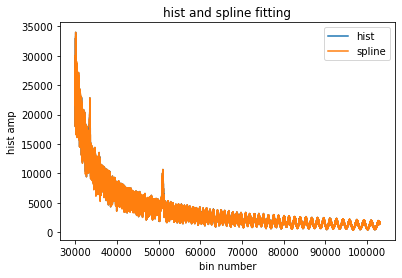

In [9]:
plt.plot(termbins, termcountarr, label="hist")
plt.plot(csx, cs(csx), label="spline")
plt.title("hist and spline fitting")
plt.xlabel("bin number")
plt.ylabel("hist amp")
plt.legend()

In [10]:
def examineinl(edges, binsnum, edgemethodname): #here binsnum is binnumbers 
    idealmids = 0.5 + binsnum    
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    plt.plot(binsnum, inl)
    plt.title(f'{edgemethodname} inl by bin number')
    plt.xlabel("bin number")
    plt.ylabel("inl")
    plt.grid()

def makenarrow(bcvar, right, left):
    width = right - left
    width *= (1-bcvar) #reduce the lenght of the bin 
    right = width + left 
    bcvar *= 0.85 #make the change amount reduced by 50% 
    return right, bcvar
    
def makewide(bcvar, right, left): #function increases the bin width 
    width = right - left
    width *= (1+bcvar)
    right = width + left 
    bcvar *= 0.85 
    return right, bcvar

def buildedges(cs, counts): #reduces
    edges = [30000] #define the first edge to be 30k 
    for a in range(len(counts)): 
        left = edges[-1]
        if left > 103000: #prevent interpolation beyond what we have for values
            break
        inte = scipy.interpolate.CubicSpline.integrate(cs, left, left+1) #generically make the width = 1        
        right = left + 1 
        x = 0 #a counter for issues 
        bcvar = 0.25 #bin change variable (start with 25% change)
        while len(edges) != a+2: 
            if counts[a]-0.01 < inte < counts[a] +0.01: #make the requirement sufficient
                edges.append(right)  
            elif counts[a] > inte: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                inte = scipy.interpolate.CubicSpline.integrate(cs, left, right)       
            elif counts[a] < inte:  #bin is too big
                right, bcvar = makenarrow(bcvar, right, left)
                inte = scipy.interpolate.CubicSpline.integrate(cs, left, right)
            x +=1 
    return edges

In [11]:
start = time.time()
edges = buildedges(cs, termcountarr)
end = time.time()
print("time passed", end-start)

time passed 39.89773988723755


In [12]:
print(len(edges))

72994


In [13]:
#determine if bins are always increasing 
for x in range(len(edges)): 
    if edges[x+1] < edges[x]:
        print("issue", x)

IndexError: list index out of range

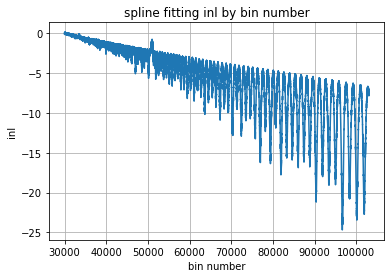

In [14]:
bins = 30000 + np.arange(0, len(edges)-1)
examineinl(edges, bins, "spline fitting")